In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import sys, os, re, glob, parse
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('notebook')
sns.set_style('white')
sns.set_palette('muted')

ligan_root = 'C:\\Users\mtr22\Code\liGAN'
sys.path.append(ligan_root)

In [2]:
# load train experiment output files
train_files = [
    'C:\\Users\\mtr22\\Code\\liGAN\\train_molport\\loss_weights\\crc_loss_weights.train_output',
]
expt_param_names = ['expt_name', 'cluster']

train_dfs = []
for train_file in train_files:
    train_df = pd.read_csv(train_file, sep=' ')
    cluster, expt_name = os.path.splitext(os.path.basename(train_file))[0].split('_', 1)
    train_df['expt_name'] = expt_name
    train_df['cluster'] = cluster
    train_dfs.append(train_df)
    print(train_file)
        
train_df = pd.concat(train_dfs)

C:\Users\mtr22\Code\liGAN\train_molport\loss_weights\crc_loss_weights.train_output


In [3]:
# parse training params from job names
from functools import lru_cache

job_param_names = ['job_name', 'variational', 'gen_loss_type', 'disc_loss_type', 'random_seed',
                   'KL_loss_weight', 'L2_loss_weight', 'GAN_loss_weight']

vae_job_name_format  = 'gen_{gen_loss_type}_{KL_loss_weight}_{L2_loss_weight}_disc_{disc_loss_type}_{GAN_loss_weight}_{random_seed}'

@lru_cache(100)
def parse_job_name(job_name):

    job_params = parse.parse(vae_job_name_format, job_name).named

    job_params['job_name'] = job_name
    job_params['variational'] = True
    
    # convert data types of numeric params
    job_params['KL_loss_weight'] = float(job_params['KL_loss_weight'])
    job_params['L2_loss_weight'] = float(job_params['L2_loss_weight'])
    job_params['GAN_loss_weight'] = float(job_params['GAN_loss_weight'])

    return pd.Series([job_params[p] for p in job_param_names])

train_df[job_param_names] = train_df['job_name'].apply(parse_job_name)

def dtype(series):
    return series.dtype

param_names = expt_param_names + job_param_names

train_df = train_df.rename(columns=dict({'test_data': 'phase'}))

train_df[param_names + ['iteration', 'phase']].agg([dtype, pd.Series.nunique, pd.Series.unique]).transpose()

,dtype,nunique,unique
expt_name,object,1,[loss_weights]
cluster,object,1,[crc]
job_name,object,27,"[gen_e_0.1_0.1_disc_x_0.1_0, gen_e_0.1_0.1_dis..."
variational,bool,1,[True]
gen_loss_type,object,1,[e]
disc_loss_type,object,1,[x]
random_seed,object,1,[0]
KL_loss_weight,float64,3,"[0.1, 1.0, 10.0]"
L2_loss_weight,float64,3,"[0.1, 1.0, 10.0]"
GAN_loss_weight,float64,3,"[0.1, 1.0, 10.0]"


In [127]:
# assign colors to job_names
from collections import OrderedDict

def get_pareto_frontier(losses):
    n_points, n_losses = losses.shape
    is_efficient = np.ones(n_points, dtype=bool)
    for i, loss in enumerate(losses):
        if is_efficient[i]:
            is_efficient[is_efficient] = np.any(losses[is_efficient] < loss, axis=1)
            is_efficient[i] = True        
    return is_efficient

top_n = 15

def get_loss_rank(loss):
    return np.maximum(1.0 - loss.argsort().argsort()/top_n, 0.0)

color_min = 0.0
color_max = 0.8
color_range = color_max - color_min

def ranks_to_color(ranks):
    return tuple(color_range * np.array(ranks) + color_min)

def weights_to_color(weights):
    return tuple(color_range*(np.log10(weights) + 1)/2 + color_min)

# get last iteration train and test output for each job
loss_names = [
    'gen_kldiv_loss',
    'gen_L2_loss',
    'gen_adv_log_loss',
]

agg_train_df = train_df[
    (train_df['phase'] == 'test')
].groupby(['job_name']).last().sort_values('gen_L2_loss').reset_index()

# get scaled loss rankings (0.0-1.0, where 1.0 is best)
loss_rank_names = []
for loss_name in loss_names:
    loss_rank_name = loss_name + '_rank'
    agg_train_df[loss_rank_name] = get_loss_rank(agg_train_df[loss_name])
    loss_rank_names.append(loss_rank_name)

agg_train_df['loss_color'] = agg_train_df[loss_rank_names].apply(ranks_to_color, axis=1)

loss_weight_names = ['KL_loss_weight', 'L2_loss_weight', 'GAN_loss_weight']
agg_train_df['weight_color'] = agg_train_df[loss_weight_names].apply(weights_to_color, axis=1)

agg_train_df['is_pareto'] = get_pareto_frontier(agg_train_df[loss_names].values)

color_col = 'weight_color'
color_map = OrderedDict((row['job_name'], row[color_col]) for i, row in agg_train_df.iterrows())

hue_order = list(color_map.keys())
colors = list(color_map.values())
pareto_front = set(agg_train_df[agg_train_df['is_pareto']]['job_name'].values)

agg_train_df.head(top_n+2)

,job_name,Unnamed: 0,iteration,phase,disc_log_loss,disc_iter,disc_grad_norm,gen_kldiv_loss,gen_L2_loss,gen_adv_log_loss,...,random_seed,KL_loss_weight,L2_loss_weight,GAN_loss_weight,gen_kldiv_loss_rank,gen_L2_loss_rank,gen_adv_log_loss_rank,loss_color,weight_color,is_pareto
0,gen_e_0.1_10_disc_x_10_0,1003,100000,test,2.907322,100000.0,0.988940,945.396613,40.502651,8.146150,...,0,0.1,10.0,10.0,0.000000,1.000000,0.000000,"(0.0, 0.8, 0.0)","(0.0, 0.8, 0.8)",True
1,gen_e_0.1_10_disc_x_0.1_0,1103,100000,test,0.070802,100000.0,0.982186,937.896570,41.603209,9.277991,...,0,0.1,10.0,0.1,0.000000,0.933333,0.000000,"(0.0, 0.7466666666666667, 0.0)","(0.0, 0.8, 0.0)",True
2,gen_e_0.1_10_disc_x_1_0,2001,100000,test,1.756424,100000.0,1.000000,974.876019,41.714526,7.465883,...,0,0.1,10.0,1.0,0.000000,0.866667,0.000000,"(0.0, 0.6933333333333334, 0.0)","(0.0, 0.8, 0.4)",True
3,gen_e_0.1_1_disc_x_1_0,2001,100000,test,2.313629,100000.0,1.000000,242.414151,55.189987,6.727679,...,0,0.1,1.0,1.0,0.000000,0.800000,0.133333,"(0.0, 0.6400000000000001, 0.10666666666666665)","(0.0, 0.4, 0.4)",True
4,gen_e_0.1_1_disc_x_10_0,2001,100000,test,0.735428,100000.0,1.000000,260.356252,57.481601,0.403890,...,0,0.1,1.0,10.0,0.000000,0.733333,0.933333,"(0.0, 0.5866666666666668, 0.7466666666666667)","(0.0, 0.4, 0.8)",True
5,gen_e_0.1_1_disc_x_0.1_0,2001,100000,test,0.711740,100000.0,1.000000,238.658275,57.759170,7.052411,...,0,0.1,1.0,0.1,0.000000,0.666667,0.066667,"(0.0, 0.5333333333333334, 0.05333333333333332)","(0.0, 0.4, 0.0)",True
6,gen_e_1_10_disc_x_0.1_0,1003,100000,test,0.172903,100000.0,0.765659,238.960570,58.130043,13.106239,...,0,1.0,10.0,0.1,0.000000,0.600000,0.000000,"(0.0, 0.48, 0.0)","(0.4, 0.8, 0.0)",False
7,gen_e_1_10_disc_x_1_0,1203,100000,test,1.410436,100000.0,0.945788,252.104533,59.105269,11.007454,...,0,1.0,10.0,1.0,0.000000,0.533333,0.000000,"(0.0, 0.4266666666666667, 0.0)","(0.4, 0.8, 0.4)",False
8,gen_e_1_10_disc_x_10_0,1899,94900,test,1.451474,94900.0,1.000000,265.594716,64.857908,5.607801,...,0,1.0,10.0,10.0,0.000000,0.466667,0.266667,"(0.0, 0.37333333333333335, 0.21333333333333337)","(0.4, 0.8, 0.8)",False
9,gen_e_0.1_0.1_disc_x_10_0,1101,99900,test,0.831259,99900.0,1.000000,85.332479,116.654712,0.270501,...,0,0.1,0.1,10.0,0.000000,0.400000,1.000000,"(0.0, 0.32000000000000006, 0.8)","(0.0, 0.0, 0.8)",True


c:\users\mtr22\code\miniconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


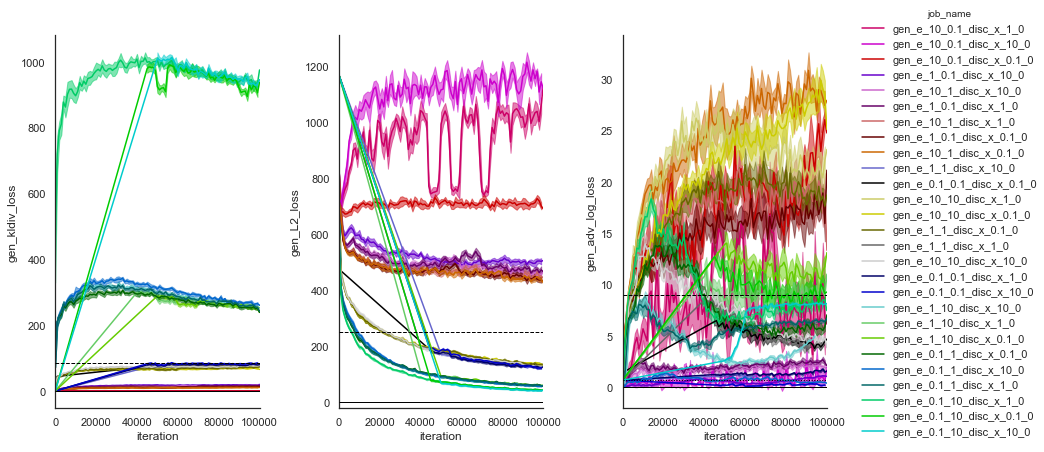

In [128]:
from results import plot_lines

plot_df = train_df[
    (train_df['phase'] == 'test')
]

iter_resolution = 1000
plot_df['iteration'] = (plot_df['iteration']//iter_resolution)*iter_resolution

x = 'iteration'
y = [
    'gen_kldiv_loss',   # red
    'gen_L2_loss',      # green
    'gen_adv_log_loss', # blue
]
hue = 'job_name'

fig = plot_lines('loss_weights_lines.png', plot_df, x=x, y=y, hue=hue,
                 n_cols=4, height=6, width=4, lgd_h=1.05,
                 hue_order=hue_order[::-1], colors=colors[::-1])

sns.despine(fig)

baselines = [85, 250, 9, 0.2] # est. from loss_types/gen_e_disc_x_0 at iteration 40-50k

for ax, bl in zip(fig.axes, baselines):
    xlim = ax.get_xlim()
    ax.hlines(bl, xlim[0], xlim[1], color='k', linestyle='--', linewidth=1, zorder=100)
    ax.set_xlim(*xlim)


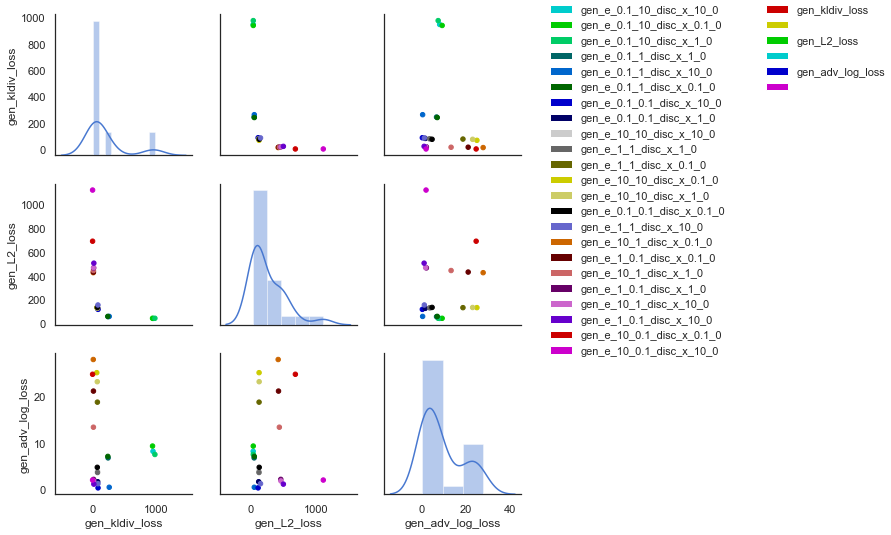

In [129]:
import matplotlib
from results import my_dist_plot
from collections import defaultdict

y = [
    'gen_kldiv_loss',
    'gen_L2_loss',
    'gen_adv_log_loss',
]

plot_df = agg_train_df[
    #(agg_train_df['gen_kldiv_loss'] < 1000) &
    #(agg_train_df['gen_L2_loss'] < 200) &
    #(agg_train_df['gen_adv_log_loss'] < 20) &
    (agg_train_df['is_pareto'])
]

plot_file = 'loss_weight_corr.png'
height = 2.5
width = 2.5

g = sns.PairGrid(
    plot_df,
    x_vars=y,
    y_vars=y,
    height=height,
    aspect=width/float(height),
    diag_sharey=False,
)

g.map_diag(my_dist_plot)
g.map_offdiag(plt.scatter, s=20, color=plot_df[color_col])
fig = g.fig

# job names legend
handles, labels = [], []
for i, row in plot_df.iterrows():
    p = matplotlib.patches.Patch(facecolor=row[color_col])
    handles.append(p)
    labels.append(row['job_name'])

fig.legend(handles, labels, loc='upper left', bbox_to_anchor=(1.0, 1.0), frameon=False)

# loss colors legend
handles, labels = [], []
for i in range(3):
    color = tuple([color_max if j == i else color_min for j in range(3)])
    label = y[i] #'{} = {:.2f}'.format(y[i], plot3_df[y[i]].min())
    p = matplotlib.patches.Patch(facecolor=color)
    handles.append(p)
    labels.append(label)

    color = tuple([color_max if j in [i, (i+1)%3] else color_min for j in range(3)])
    label = ''
    p = matplotlib.patches.Patch(facecolor=color),
    handles.append(p)
    labels.append(label)
    
fig.legend(handles, labels, loc='upper left', bbox_to_anchor=(1.4, 1.0), frameon=False)

fig.tight_layout()
plt.subplots_adjust(wspace=0.2, hspace=0.2)
fig.savefig(plot_file, bbox_inches='tight')

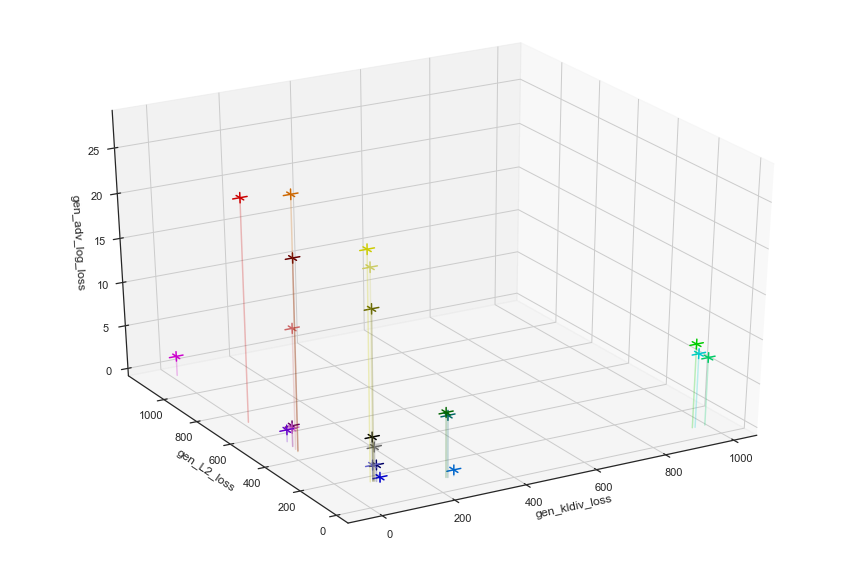

In [130]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

x = 'gen_kldiv_loss'
y = 'gen_L2_loss'
z = 'gen_adv_log_loss'

x_size = (plot_df[x].max() - plot_df[x].min()) * 0.02
y_size = (plot_df[y].max() - plot_df[y].min()) * 0.02
z_size = (plot_df[z].max() - plot_df[z].min()) * 0.02
 
for i, row in plot_df.iterrows():
    color = row[color_col]
    x_ = [row[x] - x_size, row[x] + x_size]
    y_ = [row[y], row[y]]
    z_ = [row[z], row[z]]
    ax.plot(x_, y_, z_, c=color, alpha=1.0)
    x_ = [row[x], row[x]]
    y_ = [row[y] - y_size, row[y] + y_size]
    z_ = [row[z], row[z]]
    ax.plot(x_, y_, z_, c=color, alpha=1.0)
    x_ = [row[x], row[x]]
    y_ = [row[y], row[y]]
    z_ = [row[z] - z_size, row[z] + z_size]
    ax.plot(x_, y_, z_, c=color, alpha=1.0)

x_lim = ax.get_xlim()
y_lim = ax.get_ylim()
z_lim = ax.get_zlim()

for i, row in plot_df.iterrows():
    color = row[color_col]
    #x_ = [row[x], x_lim[1]]
    #y_ = [row[y], row[y]]
    #z_ = [row[z], row[z]]
    #ax.plot(x_, y_, z_, c=color, alpha=0.25)
    #x_ = [row[x], row[x]]
    #y_ = [row[y], y_lim[1]]
    #z_ = [row[z], row[z]]
    #ax.plot(x_, y_, z_, c=color, alpha=0.25)
    x_ = [row[x], row[x]]
    y_ = [row[y], row[y]]
    z_ = [z_lim[0], row[z]]
    ax.plot(x_, y_, z_, c=color, alpha=0.25)

ax.set_xlim(x_lim)
ax.set_ylim(y_lim)
ax.set_zlim(z_lim)
    
ax.view_init(30, 180+60)

ax.set_xlabel(x)
ax.set_ylabel(y)
ax.set_zlabel(z)

fig.tight_layout()

In [131]:
fit_files = [
    'C:\\Users\\mtr22\\Code\\liGAN\\train_molport\\loss_weights\\crc_fit_molport2.gen_metrics',
]
expt_param_names = ['expt_name', 'cluster']

fit_dfs = []
for fit_file in fit_files:
    fit_df = pd.read_csv(fit_file, sep=' ')
    cluster, expt_name = os.path.splitext(os.path.basename(fit_file))[0].split('_', 1)
    fit_df['expt_name'] = expt_name
    fit_df['cluster'] = cluster
    fit_dfs.append(fit_df)
    print(fit_file)
        
fit_df = pd.concat(fit_dfs)

C:\Users\mtr22\Code\liGAN\train_molport\loss_weights\crc_fit_molport2.gen_metrics


In [158]:
from functools import lru_cache

job_param_names = ['job_name', 'variational', 'gen_loss_type', 'KL_loss_weight', 'L2_loss_weight',
                   'disc_loss_type', 'GAN_loss_weight', 'random_seed', 'train_job_name', 'loss_weights', 'iteration', 'prior']

train_job_name_format = 'gen_{gen_loss_type}_{KL_loss_weight}_{L2_loss_weight}_disc_{disc_loss_type}_{GAN_loss_weight}_{random_seed}'
fit_job_name_format = 'gen_{gen_loss_type}_{KL_loss_weight}_{L2_loss_weight}_disc_{disc_loss_type}_{GAN_loss_weight}_{random_seed}_{iteration}_{fit_options}'

@lru_cache(100)
def parse_job_name(job_name):

    job_params = parse.parse(fit_job_name_format, job_name).named
    variational = True

    job_params['job_name'] = job_name
    job_params['variational'] = variational
    
    # default values for params not present in each name format
    # TODO

    # parse fit_options flags into new boolean params
    fit_options = job_params['fit_options']
    job_params['prior']           = 'p' in fit_options
    job_params['random_rotation'] = 'r' in fit_options
    
    job_params['train_job_name'] = train_job_name_format.format(**job_params)
    
    # convert data types of numeric params
    job_params['KL_loss_weight'] = float(job_params['KL_loss_weight'])
    job_params['L2_loss_weight'] = float(job_params['L2_loss_weight'])
    job_params['GAN_loss_weight'] = float(job_params['GAN_loss_weight'])
    job_params['iteration']   = int(job_params['iteration'])
    job_params['random_seed'] = int(job_params['random_seed'])
    
    # add other params
    job_params['loss_weights'] = str((job_params['KL_loss_weight'],
                                      job_params['L2_loss_weight'],
                                      job_params['GAN_loss_weight']))

    return pd.Series([job_params[p] for p in job_param_names])

fit_df[job_param_names] = fit_df['job_name'].apply(parse_job_name)

def dtype(series):
    return series.dtype

param_names = expt_param_names + job_param_names

fit_df[param_names + ['lig_name']].agg([dtype, pd.Series.nunique, pd.Series.unique]).transpose()

,dtype,nunique,unique
expt_name,object,1,[fit_molport2]
cluster,object,1,[crc]
job_name,object,443,"[gen_e_0.1_0.1_disc_x_0.1_0_10000_pr, gen_e_0...."
variational,bool,1,[True]
gen_loss_type,object,1,[e]
KL_loss_weight,float64,3,"[0.1, 10.0, 1.0]"
L2_loss_weight,float64,3,"[0.1, 10.0, 1.0]"
disc_loss_type,object,1,[x]
GAN_loss_weight,float64,3,"[0.1, 10.0, 1.0]"
random_seed,int64,1,[0]


In [133]:
fit_df['lig_fit_exact_types'] = (fit_df['lig_fit_type_diff'] == 0) * 100
fit_df['lig_gen_fit_exact_types'] = (fit_df['lig_gen_fit_type_diff'] == 0) * 100

fit_df['lig_gen_fit_add_dvalid'] = (fit_df['lig_gen_fit_add_valid'].astype(int) - fit_df['lig_gen_fit_valid'].astype(int))

fit_df['lig_gen_fit_add_logE'] = np.log10(fit_df['lig_gen_fit_add_E'])
fit_df['lig_gen_fit_add_min_logE'] = np.log10(fit_df['lig_gen_fit_add_min_E'])

c:\users\mtr22\code\miniconda3\lib\site-packages\pandas\core\series.py:679: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\users\mtr22\code\miniconda3\lib\site-packages\pandas\core\series.py:679: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [141]:
# assign colors to job_names

fit_df['hue_order'] = fit_df['train_job_name'].map(list(color_map.keys()).index)
fit_df[color_col] = fit_df['train_job_name'].map(color_map.__getitem__)
fit_df['is_pareto'] = fit_df['train_job_name'].map(pareto_front.__contains__)

param_names = param_names

agg_fit_df = fit_df \
    .groupby(['train_job_name', 'iteration', 'prior', 'hue_order', color_col]).mean().reset_index() \
    .groupby(['train_job_name', 'prior', 'hue_order', color_col]).last().reset_index()

agg_fit_df = agg_fit_df.sort_values('hue_order')

hue_order2 = list(agg_fit_df['hue_order'].values)
colors2 = list(agg_fit_df[color_col].values)

agg_fit_df[~agg_fit_df['prior']].head(top_n+2)

,train_job_name,prior,hue_order,weight_color,iteration,Unnamed: 0,sample_idx,lig_norm,lig_gen_norm,lig_latent_norm,...,array_idx,variational,KL_loss_weight,L2_loss_weight,GAN_loss_weight,random_seed,lig_gen_fit_add_dvalid,lig_gen_fit_add_logE,lig_gen_fit_add_min_logE,is_pareto
8,gen_e_0.1_10_disc_x_10_0,False,0,"(0.0, 0.8, 0.8)",80000,4.5,4.5,37.132387,36.640408,26.281315,...,5.500000,1.0,0.1,10.0,10.0,0.0,0.420000,4.560944,2.214719,1.0
6,gen_e_0.1_10_disc_x_0.1_0,False,1,"(0.0, 0.8, 0.0)",90000,4.5,4.5,37.132387,36.315752,26.521795,...,5.500000,1.0,0.1,10.0,0.1,0.0,0.320000,4.504337,2.131746,1.0
10,gen_e_0.1_10_disc_x_1_0,False,2,"(0.0, 0.8, 0.4)",90000,4.5,4.5,37.132387,36.070147,26.924308,...,5.500000,1.0,0.1,10.0,1.0,0.0,0.370000,4.495713,2.160257,1.0
16,gen_e_0.1_1_disc_x_1_0,False,3,"(0.0, 0.4, 0.4)",90000,4.5,4.5,37.132387,36.373272,30.821844,...,5.500000,1.0,0.1,1.0,1.0,0.0,0.440000,4.825326,2.075442,1.0
14,gen_e_0.1_1_disc_x_10_0,False,4,"(0.0, 0.4, 0.8)",90000,4.5,4.5,37.132387,37.172152,30.538211,...,5.500000,1.0,0.1,1.0,10.0,0.0,0.500000,4.827099,2.205760,1.0
12,gen_e_0.1_1_disc_x_0.1_0,False,5,"(0.0, 0.4, 0.0)",90000,4.5,4.5,37.132387,36.205389,30.904137,...,5.500000,1.0,0.1,1.0,0.1,0.0,0.610000,5.125418,2.067107,1.0
42,gen_e_1_10_disc_x_0.1_0,False,6,"(0.4, 0.8, 0.0)",80000,4.5,4.5,37.132387,35.041183,30.573806,...,5.500000,1.0,1.0,10.0,0.1,0.0,0.580000,4.808931,2.232782,0.0
46,gen_e_1_10_disc_x_1_0,False,7,"(0.4, 0.8, 0.4)",80000,4.5,4.5,37.132387,35.698989,30.562654,...,5.500000,1.0,1.0,10.0,1.0,0.0,0.620000,4.845537,2.173124,0.0
44,gen_e_1_10_disc_x_10_0,False,8,"(0.4, 0.8, 0.8)",80000,4.5,4.5,37.132387,36.673619,30.767246,...,5.500000,1.0,1.0,10.0,10.0,0.0,0.570000,4.998920,2.069959,0.0
2,gen_e_0.1_0.1_disc_x_10_0,False,9,"(0.0, 0.0, 0.8)",90000,4.5,4.5,37.132387,38.063974,31.710418,...,5.500000,1.0,0.1,0.1,10.0,0.0,0.600000,5.426713,2.395078,1.0


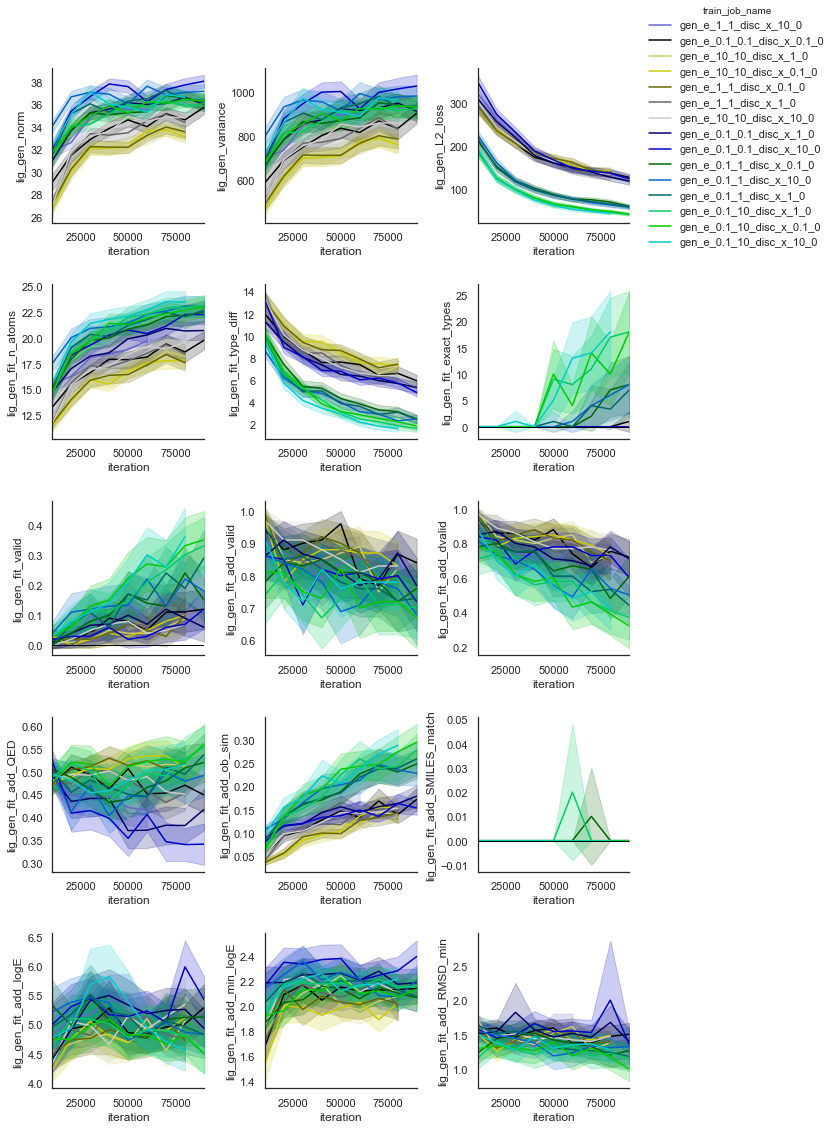

In [135]:
from results import plot_lines

plot_df = fit_df[
    (~fit_df['prior']) &
    (fit_df['train_job_name'].isin(agg_fit_df[
        agg_fit_df['lig_gen_L2_loss'] < 250
    ]['train_job_name'])) &
    (fit_df['is_pareto'])
]

hue_order = [j for j in color_map.keys() if j in set(plot_df['train_job_name'].values)]
colors = [color_map[j] for j in hue_order]

x = 'iteration'
y = [
    'lig_gen_norm',
    'lig_gen_variance',
    'lig_gen_L2_loss',
    
    'lig_gen_fit_n_atoms',
    'lig_gen_fit_type_diff',
    'lig_gen_fit_exact_types',
    
    'lig_gen_fit_valid',
    'lig_gen_fit_add_valid',
    'lig_gen_fit_add_dvalid',
    
    'lig_gen_fit_add_QED',
    'lig_gen_fit_add_ob_sim',
    'lig_gen_fit_add_SMILES_match',
    
    'lig_gen_fit_add_logE',
    'lig_gen_fit_add_min_logE',
    'lig_gen_fit_add_RMSD_min',    
]
hue = 'train_job_name'

fig = plot_lines('loss_weights_fit_lines.png', plot_df, x=x, y=y, hue=hue, alpha=1/5,
                  n_cols=3, height=3, width=3, lgd_h=1.05, hue_order=hue_order[::-1], colors=colors[::-1])
sns.despine(fig)

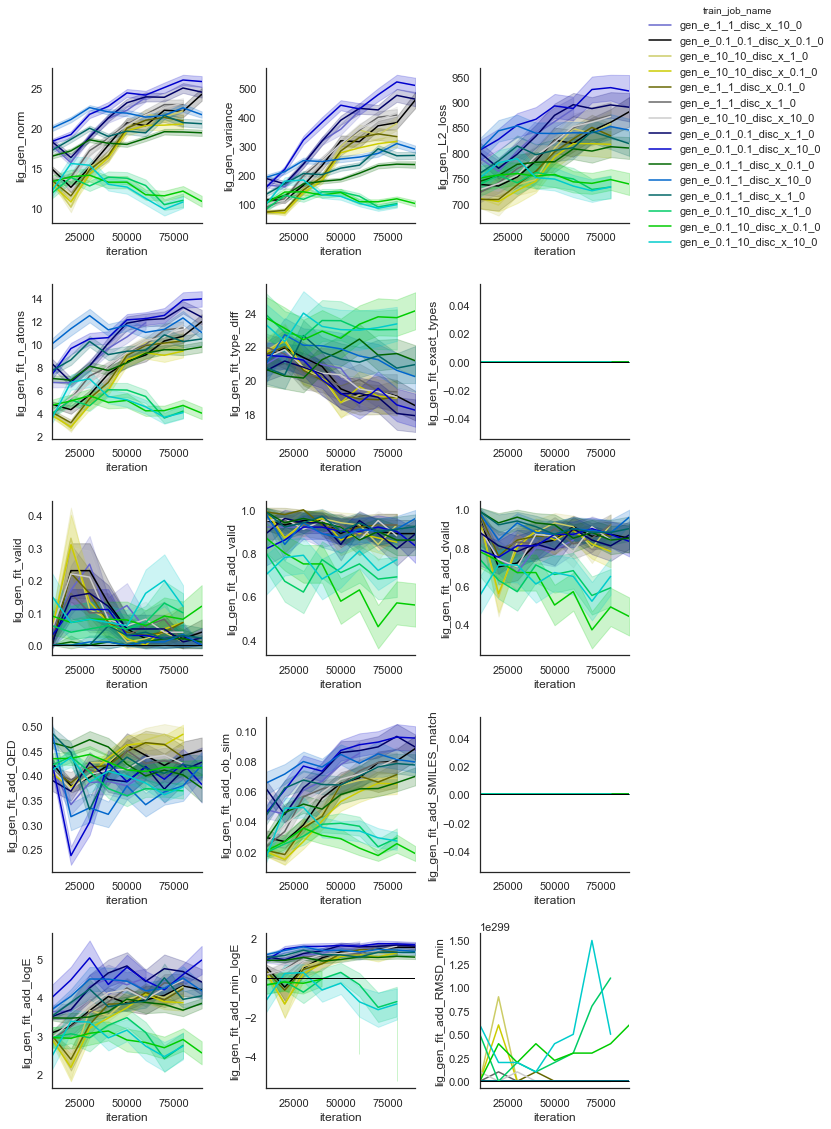

In [136]:
plot_df = fit_df[
    fit_df['prior'] &
    (fit_df['train_job_name'].isin(agg_fit_df[
        agg_fit_df['lig_gen_L2_loss'] < 250
    ]['train_job_name'])) &
    fit_df['is_pareto']
]

x = 'iteration'
y = y
hue = 'train_job_name'

fig = plot_lines('loss_weights_fit_lines.png', plot_df, x=x, y=y, hue=hue, alpha=1/5,
                  n_cols=3, height=3, width=3, lgd_h=1.05, hue_order=hue_order[::-1], colors=colors[::-1])
sns.despine(fig)

In [159]:
agg_fit_df.set_index(param_names).unstack().columns #['lig_gen_fit_n_atoms']

KeyError: "None of ['expt_name', 'cluster', 'job_name', 'gen_loss_type', 'disc_loss_type', 'loss_weights'] are in the columns"

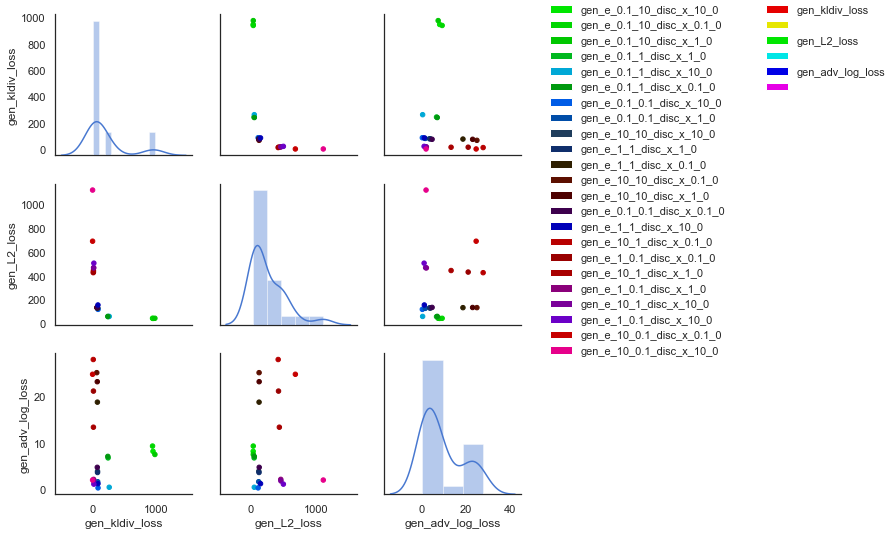

In [125]:
import matplotlib
from results import my_dist_plot
from collections import defaultdict

plot_df = agg_fit_df[
    #(agg_train_df['gen_kldiv_loss'] < 1000) &
    #(agg_train_df['gen_L2_loss'] < 200) &
    #(agg_train_df['gen_adv_log_loss'] < 20) &
    (agg_fit_df['is_pareto'])
]



asdf

y = [
    'lig_gen_fit_',
    'gen_L2_loss',
    'gen_adv_log_loss',
]

plot_file = 'loss_weight_corr.png'
height = 2.5
width = 2.5

g = sns.PairGrid(
    plot_df,
    x_vars=y,
    y_vars=y,
    height=height,
    aspect=width/float(height),
    diag_sharey=False,
)

g.map_diag(my_dist_plot)
g.map_offdiag(plt.scatter, s=20, color=plot_df['loss_color'])
fig = g.fig

# job names legend
handles, labels = [], []
for i, row in plot_df.iterrows():
    p = matplotlib.patches.Patch(facecolor=row['loss_color'])
    handles.append(p)
    labels.append(row['job_name'])

fig.legend(handles, labels, loc='upper left', bbox_to_anchor=(1.0, 1.0), frameon=False)

# loss colors legend
handles, labels = [], []
for i in range(3):
    color = tuple([color_max if j == i else color_min for j in range(3)])
    label = y[i] #'{} = {:.2f}'.format(y[i], plot3_df[y[i]].min())
    p = matplotlib.patches.Patch(facecolor=color)
    handles.append(p)
    labels.append(label)

    color = tuple([color_max if j in [i, (i+1)%3] else color_min for j in range(3)])
    label = ''
    p = matplotlib.patches.Patch(facecolor=color),
    handles.append(p)
    labels.append(label)
    
fig.legend(handles, labels, loc='upper left', bbox_to_anchor=(1.4, 1.0), frameon=False)

fig.tight_layout()
plt.subplots_adjust(wspace=0.2, hspace=0.2)
fig.savefig(plot_file, bbox_inches='tight')

NameError: name 'last_y' is not defined

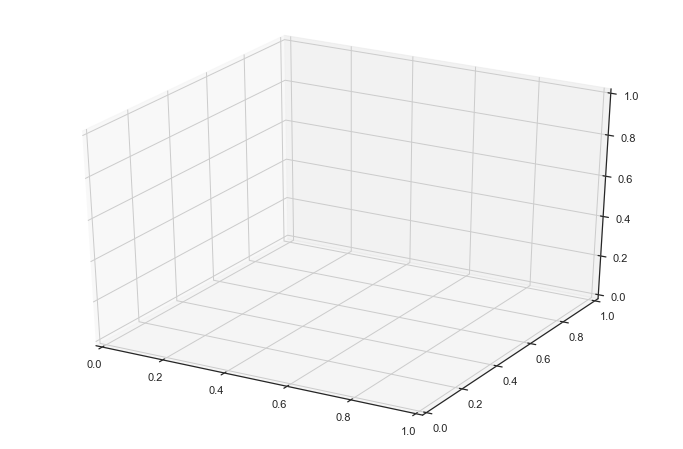

In [126]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

x, y, z = last_y

for i, row in plot4_df.iterrows():
    x_ = [row[x], row[x]]
    y_ = [row[y], row[y]]
    z_ = [0, row[z]]
    color = row['loss_color']
    ax.plot(x_, y_, z_, c=color, alpha=1.0)
    
get_range = lambda x: (x[1] - x[0])
x_size = get_range(ax.get_xlim()) * 0.02
y_size = get_range(ax.get_ylim()) * 0.02
z_size = get_range(ax.get_zlim()) * 0.02
 
for i, row in plot4_df.iterrows():
    color = row['loss_color']
    x_ = [row[x] - x_size, row[x] + x_size]
    y_ = [row[y], row[y]]
    z_ = [row[z], row[z]]
    ax.plot(x_, y_, z_, c=color, alpha=1.0)
    x_ = [row[x], row[x]]
    y_ = [row[y] - y_size, row[y] + y_size]
    z_ = [row[z], row[z]]
    ax.plot(x_, y_, z_, c=color, alpha=1.0)
    #x_ = [row[x], row[x]]
    #y_ = [row[y], row[y]]
    #z_ = [row[z], row[z] + z_size]
    #ax.plot(x_, y_, z_, c=color, alpha=1.0)
    
ax.view_init(30, 180-60)

#ax.scatter(xs=plot3_df[x], ys=plot3_df[y], zs=plot3_df[z], c=plot3_df['loss_color'], alpha=1.0)
ax.set_xlabel(x)
ax.set_ylabel(y)
ax.set_zlabel(z)

fig.tight_layout()

In [ ]:
plot_df = fit_df.copy().groupby(['loss_weights', 'lig_name', 'sample_idx', 'prior']).last().reset_index()

In [ ]:
fig, axes = plt.subplots(4, 2, figsize=(12,8))

job_names = [
    'gen_e_0.1_1_disc_x_10_0_50000_r',
    'gen_e_0.1_1_disc_x_10_0_50000_pr',
]

y = [
    'lig_gen_fit_add_morgan_sim',
    'lig_gen_fit_add_rdkit_sim',
    'lig_gen_fit_add_maccs_sim',
    'lig_gen_fit_add_ob_sim',
]

for i, y_ in enumerate(y):
    for j, jn in enumerate(job_names):
        try:
            fit_df[fit_df['job_name'] == jn][[y_]].plot.density(xlim=(0, 1), ax=axes[i][j])
        except:
            pass

fig.tight_layout()